In [145]:
import pandas as pd
import os
from transformers import AutoModel
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import seaborn as sns
from cluster_analysis import (
    calculate_average_cosine_similarity,
    get_cluster_problems,
    plot_cluster_distributions,
)
from sklearn.cluster import (
    DBSCAN,
    AffinityPropagation,
    AgglomerativeClustering,
    KMeans)
from parallel_post_processor import ParallelPostProcessor

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

I experimented with several embedding methods, including 
- RoSBERTa;
- paraphrase-multilingual-MiniLM-L12-v2; 
- all-mpnet-base-v2

Among them, the best results were achieved using __jina-embeddings-v3__. 

jina-embeddings-v3 is a multilingual text embedding model by Jina AI. 
Equipped with Low-Rank Adaptation (LoRA), it optimizes embeddings for tasks like search, clustering, classification, and text matching. 

We will select task="separation", which was trained for clustering tasks.

In [3]:
#dataset
path_to_data = os.getcwd() + "/dataset/dataset_for_training.csv"
data_problem = pd.read_csv(path_to_data, sep=",")

In [4]:
# This code transforms the data in the problems column from a string format with; 
# as a delimiter into a clean and normalized list of problems, with each problem represented in a separate row.
data_problem['problems'] = data_problem['problems'].str.split(';')
data_problem = data_problem.explode('problems')
data_problem['problems'] = data_problem['problems'].str.strip().str.lower()
data_problem = data_problem.dropna(subset=['problems'])

In [ ]:
# Initialize the embeddings model
jina_embeddings_model = AutoModel.from_pretrained(
    "jinaai/jina-embeddings-v3", trust_remote_code=True)
texts = data_problem['problems'].tolist()
embeddings_jina = jina_embeddings_model.encode(texts, task="separation")

In [5]:
path_to_emb = os.getcwd() + "/dataset/embeddings_jina.npy"
#np.save(path_to_emb, embeddings_jina)
embeddings_jina = np.load(path_to_emb)

##### Next, we will build clusters using several methods, namely:
- DBSCAN;
- K-means;
- Hierarchical clustering;
- Affinity propagation.

The parameters were preselected empirically.

##### We will evaluate each clustering based on the following criteria:

- The distribution of points across classes (the number of points in each class).
- The average __cosine similarity__ within each class.

In [9]:
# dbscan
eps = 0.05
min_samples = 10
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
labels = dbscan.fit_predict(embeddings_jina)
data_problem['dbscan_cluster'] = labels

In [8]:
# K-means
num_clusters = 1500
kmeans = KMeans(n_clusters=num_clusters)
data_problem['kmeans_cluster'] = kmeans.fit_predict(embeddings_jina)

In [10]:
# Hierarchical clustering
num_clusters = 1500
agglo = AgglomerativeClustering(n_clusters=num_clusters, linkage='complete')
agglo_labels = agglo.fit_predict(embeddings_jina)
data_problem['agglo_cluster'] = agglo_labels

In [ ]:
aff_prop_model = AffinityPropagation(max_iter=800)
aff_prop_labels = aff_prop_model.fit_predict(embeddings_jina)
data_problem['aff_prop'] = aff_prop_labels

__Analysis of Clustering Methods__

We visualized the distribution of problems across clusters. In addition to this visualization, the clustering results of each method were evaluated empirically by examining the problems assigned to each cluster and assessing how well the grouping aligned with our expectations. Based on this evaluation of cluster quality, we chose Affinity Propagation as the final method. Below, we provide a brief commentary on each clustering method.

- DBSCAN performed poorly. More than half of the elements were assigned to the "noise" cluster. We were unable to empirically select parameters for this method. Further work is needed to optimize parameter selection for DBSCAN.

- KMeans Clustering (kmeans_cluster) performed nearly as well as aff_prop. Many clusters identified by kmeans_cluster overlapped with those created by Affinity Propagation (aff_prop).

- Agglomerative Clustering (agglo_cluster) created clusters of uneven sizes. Some clusters were very small, while others were overly large. The small clusters are problematic because they are too few in number to analyze statistically. Additionally, the overly large clusters appeared too broad based on their output and could benefit from further splitting into smaller, more specific clusters.

- Affinity Propagation (aff_prop) was selected as the best method. It provided clusters of a reasonable size—not too broad and not too specific. This balance made it the most suitable choice. Additionally, aff_prop produced clusters containing single elements, which can be considered as "outliers."

#### Conclusion

Clustering is a highly subjective task that requires a clear understanding of the researcher's goals. The choice of the number of clusters is critical, especially for methods where this parameter must be set manually. The number of clusters acts as a tool to balance the desired granularity of the results.

For example, in our user problem dataset, we must decide whether problems like "I lost my homework," "My dog ate my homework," and "I was kicked out of class" should all be grouped under a general category such as "school problems," or whether the first two should form a separate cluster like "missing homework." Similarly, should "bipolar disorder" and "I have depression" belong to one broad category like "mental health issues," or should each be assigned to its own cluster?

In our case, aff_prop maintained a good balance between overly broad and overly specific clustering.



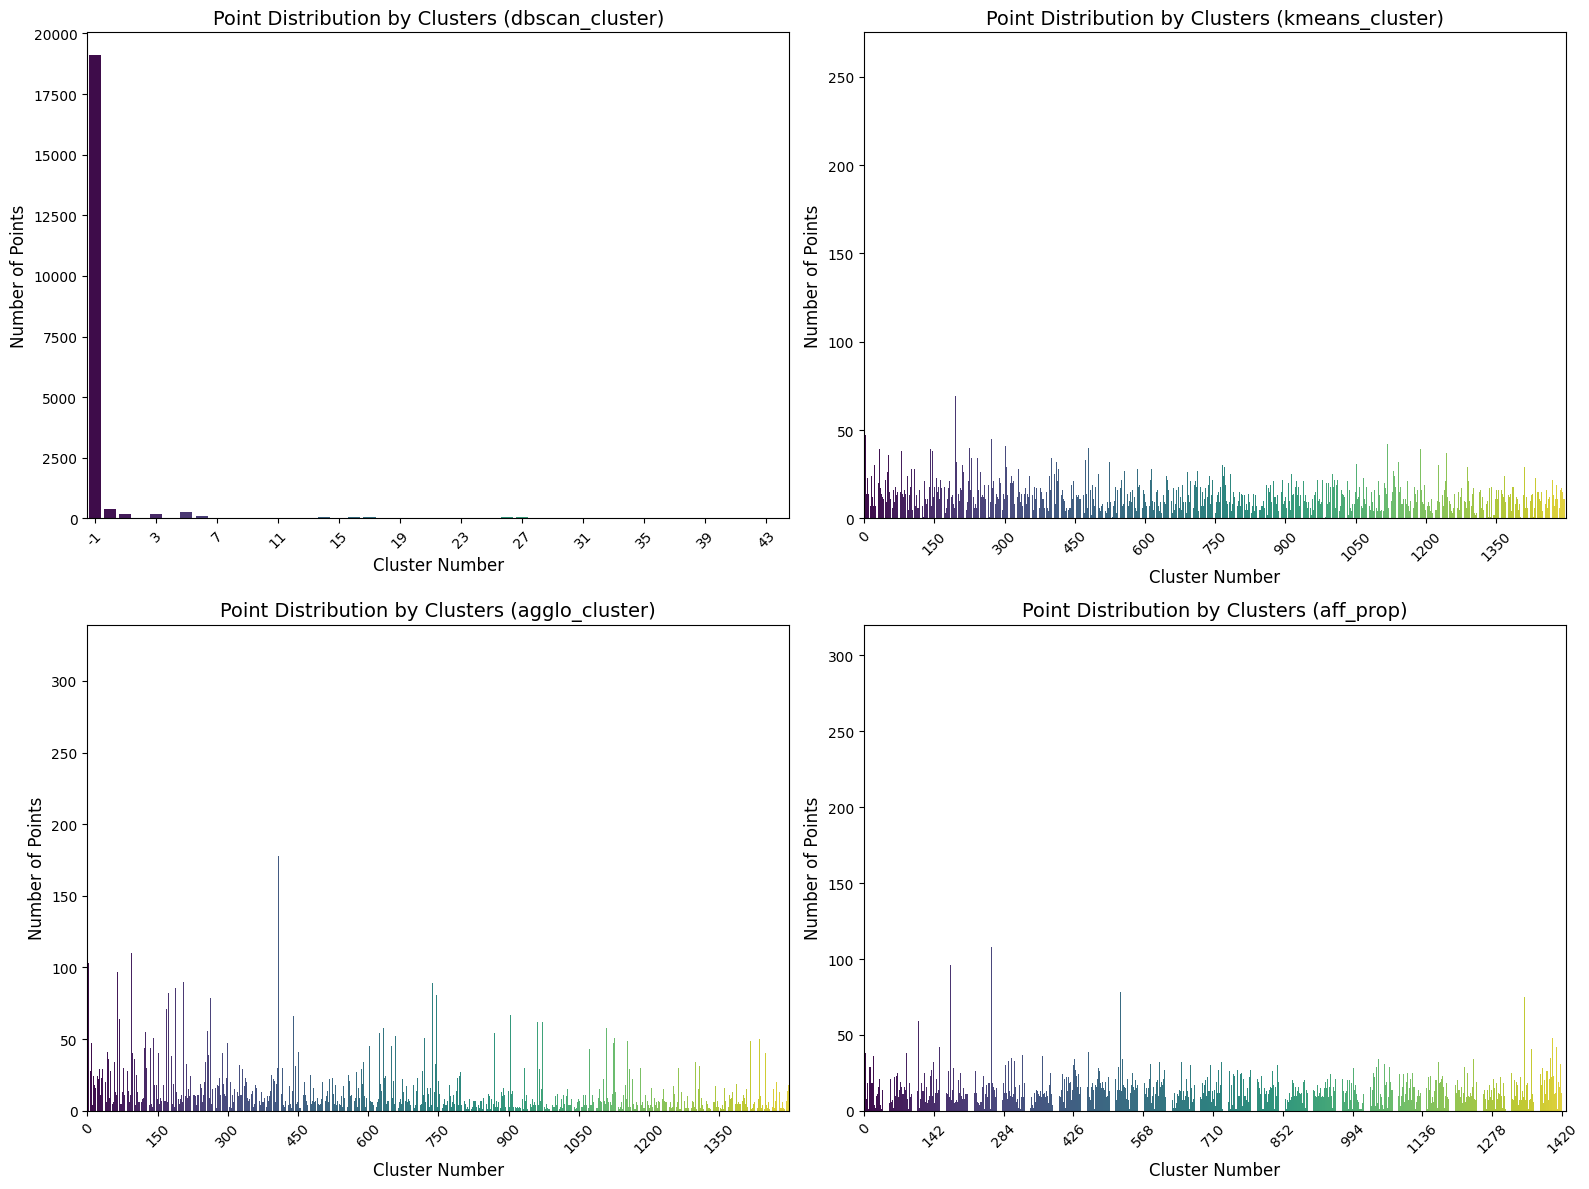

In [11]:
cluster_columns = ['dbscan_cluster','kmeans_cluster', 'agglo_cluster', 'aff_prop']
plot_cluster_distributions(data=data_problem, cluster_columns=cluster_columns)

In [12]:
results = {
    column: calculate_average_cosine_similarity(
        data=data_problem, cluster_column=column, embeddings=embeddings_jina)
    for column in cluster_columns
}

for method, similarities in results.items():
    mean_similarity = np.mean(
        [val for val in similarities.values() if val is not None])
    print(f"{method}: Average similarity = {mean_similarity:.4f}")

dbscan_cluster: Average similarity = 0.6671
kmeans_cluster: Average similarity = 0.6686
agglo_cluster: Average similarity = 0.6690
aff_prop: Average similarity = 0.6680


To display a few elements that were assigned to a single cluster, we use the get_cluster_problems function from the auxiliary module cluster_analysis. As we can see, the cluster with the number 552 was grouped logically and is related to the loss of a pet.

This function was also used for the empirical evaluation of the clustering methods' results.

In [67]:
# A list of problems from one of the clusters.
cluster_number = 552
problems = get_cluster_problems(
    data=data_problem, cluster_column="aff_prop", cluster_number=cluster_number, limit=15)

Problems from the cluster 552:
- пропал любимый котик
- влюбился в котика и его забрали обратно
- печаль из-за потери настоящей собаки
- печаль из-за смерти котика
- потеря любимой кошки
- похоронил питомца
- умирает твой любимый котик
- печаль из-за смерти котенка
- умерла любимая кошечка
- лишилась полноценного члена семьи ( своей любимой собаки)
- умер котёнок автора.
- потеря любимого кота
- потеря любимого кота
- потеря любимой кошки
- потеря котенка


Next, we use ChatGPT to identify the main theme of the problems grouped into a single cluster and to formulate this theme in the most general terms. The model is provided with a list of problems assigned to a cluster by the clustering method, along with a request to describe what these problems have in common using a 2-3 word summary. To achieve this, we used a class ParallelPostProcessor previously written to implement multiprocessing, allowing multiple clusters to be processed in parallel. Finally, we receive the results as a dictionary, where the key is the cluster number and the value is the model's response.

In [23]:
current_directory = os.getcwd()
configs_name = "configs/open_ai_access.json"
configs_name_path = os.path.join(current_directory, configs_name)
with open(configs_name_path, 'r') as json_file:
    open_ai_data = json.load(json_file)

path_to_labeling_data = os.path.join(current_directory, "dataset")
parallel_p_p = ParallelPostProcessor(results_dir=path_to_labeling_data, api_key=open_ai_data["api_key"], organization=open_ai_data["organization"])

In [24]:
prompt = """
Analyze the following sentences and identify the overarching theme or issue they describe. 
The sentences represent different problems separated by a period. Provide a brief and concise summary of the main problem **in Russian**. The summary must:  
1. Be as general and abstract as possible, avoiding unnecessary specifics.
2. Reflect the theme that describes the majority of the listed problems, not just one or two.
3. Include symptoms or issues explicitly described in the text, but only if they directly reflect the overarching problem. 
4. Avoid analyzing causes, speculating on reasons, or suggesting diagnoses beyond what is explicitly mentioned in the text.
Text: {text}
The response should be a single string containing general problem in 2-3 words".
"""

cluster_name_dict = parallel_p_p.process_clusters_in_batches(
    data=data_problem, cluster_column="aff_prop", prompt_template=prompt, batch_size=4, model="gpt-4o-mini", temperature=1)

In [ ]:
#let's match the clusters with their names, let's create a column aff_prop_label
data_problem["aff_prop_label"] = data_problem["aff_prop"].map(cluster_name_dict)

##### Let's provide a few examples with elements from clusters and their corresponding names. The column names will represent the cluster names. Cluster numbers will be generated randomly.

As we can see, the cluster descriptions are quite well-defined and, to some extent, reflect the problems corresponding to each cluster. They provide a general understanding of the topics covered in these clusters.

In [ ]:
list_of_example_cluster = random.sample(range(0, 1050), 4)
print("list_of_example_cluster:", list_of_example_cluster)
df_cluster_example = data_problem[data_problem["aff_prop"].isin(list_of_example_cluster)]
df_cluster_example = pd.DataFrame()

for cluster in list_of_example_cluster:
    cluster_problems = data_problem[data_problem["aff_prop"] == cluster]["problems"].tolist()
    df_cluster_example[f"Cluster {cluster}"] = pd.Series(cluster_problems)

columns_name = [cluster_name_dict[key] for key in list_of_example_cluster if key in cluster_name_dict]
df_cluster_example.columns = columns_name
df_cluster_example.loc[:10]
#[1022, 810, 939, 292]

list_of_example_cluster: [1022, 810, 939, 292]


,Боль в конечностях,Недостаток всего,Экзаменационный стресс,Опухоли в организме
0,на ноге отваливается ноготь,у тебя почти ничего не готово,беспокойство перед последним экзаменом,развивается опухоль мозга
1,онемелая часть ноги уже неделю,никакого интереса ни к чему,паника от сдачи экзаменов в автошколе,"нашли опухоль, которую не могут идентифицирова..."
2,болят колени,получаешь нихуя,переживание из-за проекта по английскому,атрофировавшийся мозг
3,опухание ноги,молоток не нужен,нет уверенности в своих силах на экзамене,"опухоль 1,1см в груди"
4,боль в ноге,ничего нет,"страх перед экзаменом, который принимает батя ...",опухоль в мозге
5,болит нога,пустые слова,запугали экзаменами,влияние опухоли на серотониновые рецепторы
6,рука болит,остаешься ни с чем,страх или неуверенность перед экзаменом,опух из-за болезни
7,болит нога,синьки ноль,паника из-за экзамена,прогрессирующая опухоль в мозгу у деда
8,шишки на ноге,ничего не готово к просмотру,беспокойство из-за егэ по географии,NaN
9,болят фаланги пальцев от долгого стояния,ничего норм не нашел,пугают единым государственным экзаменом,NaN


In [ ]:
aff_prop_label_uniq = list(cluster_name_dict.values())[1:]
embeddings_jina_1 = jina_embeddings_model.encode(aff_prop_label_uniq, task="separation")

num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters)

kmeans_labels_large = kmeans.fit_predict(embeddings_jina_1)
large_clusters = pd.DataFrame({
    "aff_prop_label_uniq": aff_prop_label_uniq,
    "kmeans_cluster": kmeans_labels_large
})

We can try to group the problems into even broader categories by clustering them again and specifying the desired number of groups.

In [128]:
list_of_example_cluster_large = random.sample(range(0, 100), 4)
print("list_of_example_cluster:", list_of_example_cluster_large)

df_cluster_example_large = pd.DataFrame() 

for cluster in list_of_example_cluster_large:
    cluster_problems = large_clusters[large_clusters["kmeans_cluster"] == cluster]["aff_prop_label_uniq"].tolist()
    if cluster_problems:  
        df_cluster_example_large[f"Cluster {cluster}"] = pd.Series(cluster_problems)

df_cluster_example_large.loc[:10]

list_of_example_cluster: [20, 58, 0, 92]


,Cluster 20,Cluster 58,Cluster 0,Cluster 92
0,Недостаток сна,Отказ в визах,Проблема пьянства,Отсутствие целей
1,Бессонница и усталость,Проблемы с документами,Проблемы с алкоголем,Недостаток самореализации
2,Бессонница и расстройства сна,Проблемы с документами,Алкогольные проблемы,Неудача и безрезультатность
3,Бессонница и усталость,Проблемы с медицинскими справками,Недостаток пива,Упущенные возможности.
4,Недостаток сна,Проблема документов,Проблемы с алкоголем,Нереализованные амбиции
5,Проблемы со сном,Проблемы с документами,Проблемы с алкоголем,Недостаток успеха
6,Бессонница,Проблемы с письмом,Потребность в алкоголе,Ошибки и неудачи
7,Недостаток сна,Проблемы с правами,Недостаток компании для выпивки.,Отсутствие перспектив
8,Проблемы со сном,NaN,Проблемы с похмельем,Отсутствие перспектив
9,Недостаток сна,NaN,Проблемы с доступностью напитков,Недостаток успеха


Let's take a closer look at our data. First, we will identify the top 15 most common problems overall. Then, using the "gender" column, we will extract the top 10 most common problems separately for males and females. Notably, the male top 10 includes clusters like "Drinking Problem" and "Alcohol Dependency," which might suggest the need to group these clusters together for better analysis.

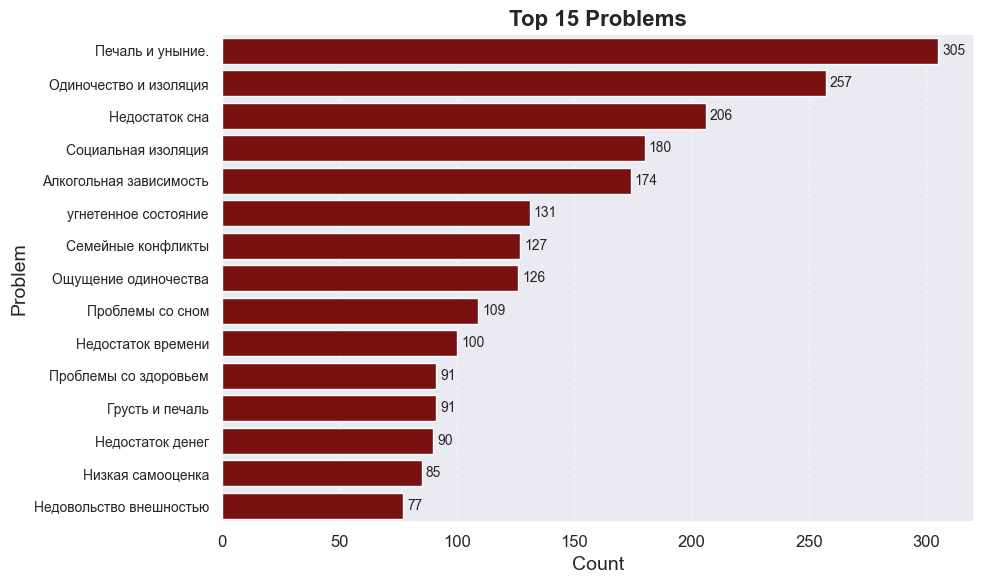

In [225]:
problem_counts = data_problem.groupby(
    'aff_prop_label').size().reset_index(name='count')

top_15_problems = problem_counts.sort_values('count', ascending=False).head(15)

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.barplot(
    data=top_15_problems,
    x='count',
    y='aff_prop_label',
    color="#8B0000",
    width=0.8
)

plt.title('Top 15 Problems', fontsize=16, weight='bold')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Problem', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge',
                  fontsize=10, padding=3)

plt.show()

In [ ]:
problem_counts = data_problem.groupby(['gender', 'aff_prop_label']).size().reset_index(name='count')
top_15_problems = problem_counts.sort_values(['gender', 'count'], ascending=[True, False]).groupby('gender').head(15)


female_problems = top_15_problems[top_15_problems['gender'].isin([' female'])]
male_problems = top_15_problems[top_15_problems['gender'].isin([' male'])]

top_15_table = pd.DataFrame({
    'Female Problems': female_problems['aff_prop_label'].values,
    'Female Count': female_problems['count'].values,
    'Male Problems': male_problems['aff_prop_label'].values,
    'Male Count': male_problems['count'].values
})

top_15_table


,Female Problems,Female Count,Male Problems,Male Count
0,Одиночество и изоляция,38,Алкогольная зависимость,60
1,Алкогольная зависимость,26,угнетенное состояние,54
2,Социальная изоляция,26,Одиночество и изоляция,46
3,Недовольство внешностью,24,Социальная изоляция,43
4,Недостаток сна,24,Печаль и уныние.,40
5,Семейные конфликты,24,Недостаток сна,36
6,Бессонница и усталость,22,Низкая самооценка,35
7,Недостаток жизненной активности,21,Семейные конфликты,35
8,Отсутствие отношений,20,Призыв в армию,33
9,Проблемы в отношениях,20,Проблемы в отношениях,29
